In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-08 07:00:03.531562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 07:00:03.531668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 07:00:03.663230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3small (Functional)   │ ?                      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.1174 - Precision: 0.5333 - Recall: 0.3694 - accuracy: 0.3472 - loss: 1.4466      

I0000 00:00:1715151633.166823     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715151633.204959     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - AUC: 0.5776 - Precision: 0.6891 - Recall: 0.5629 - accuracy: 0.5862 - loss: 0.8753

W0000 00:00:1715151640.976209     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step - AUC: 0.5805 - Precision: 0.6902 - Recall: 0.5650 - accuracy: 0.5881 - loss: 0.8718 - val_AUC: 0.9088 - val_Precision: 0.9091 - val_Recall: 0.8333 - val_accuracy: 0.8750 - val_loss: 0.3835
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.8959 - Precision: 0.7782 - Recall: 0.8211 - accuracy: 0.8078 - loss: 0.4250
Epoch 2: val_accuracy did not improve from 0.87500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - AUC: 0.8959 - Precision: 0.7772 - Recall: 0.8223 - accuracy: 0.8079 - loss: 0.4254 - val_AUC: 0.9102 - val_Precision: 0.7414 - val_Recall: 0.8958 - val_accuracy: 0.7917 - val_loss: 0.4337
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - AUC: 0.9022 - Precision: 0.7917 - Recall: 0.7910 - accuracy: 0.8101 - loss: 0.4000
Epoch 3: val_accuracy did not improve from 0.87500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - AUC: 0.9025 - Precision: 0.7918 -

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.87500
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - AUC: 0.8453 - Precision: 0.7697 - Recall: 0.8381 - accuracy: 0.7952 - loss: 0.5146 - val_AUC: 0.9023 - val_Precision: 0.8561 - val_Recall: 0.8264 - val_accuracy: 0.8438 - val_loss: 0.4519
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.8470 - Precision: 0.7646 - Recall: 0.8126 - accuracy: 0.7883 - loss: 0.4735
Epoch 7: val_accuracy did not improve from 0.87500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - AUC: 0.8479 - Precision: 0.7660 - Recall: 0.8130 - accuracy: 0.7892 - loss: 0.4722 - val_AUC: 0.9142 - val_Precision: 0.8561 - val_Recall: 0.8264 - val_accuracy: 0.8438 - val_loss: 0.3812
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.9263 - Precision: 0.7759 - Recall: 0.8941 - accuracy: 0.8381 - loss: 0.3827
Epoch 8: val_accuracy did not improve from 0.87500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - AUC: 0.9258 - Precision: 0.7760 - Recall: 0.8928 - accuracy: 0.8375 - 

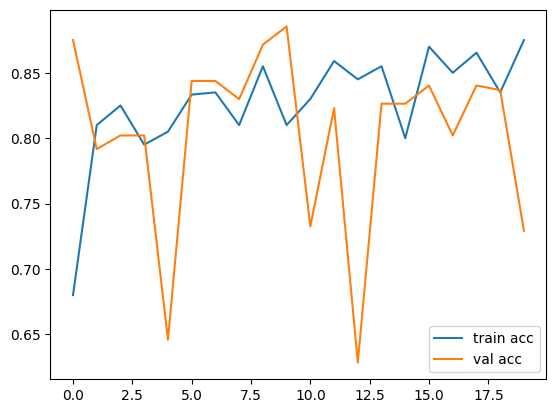

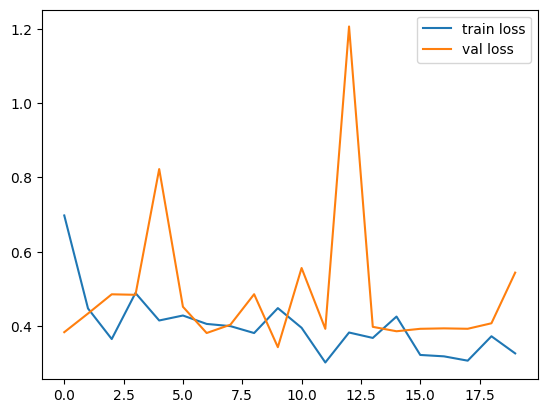

In [8]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('MobileNetV3-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('MobileNetV3-loss.png')
plt.show()

In [9]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - AUC: 0.9624 - Precision: 0.8638 - Recall: 0.9301 - accuracy: 0.8695 - loss: 0.2615


[0.26468876004219055,
 0.9626399874687195,
 0.8745387196540833,
 0.9404761791229248,
 0.8838862776756287]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0.9944587]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


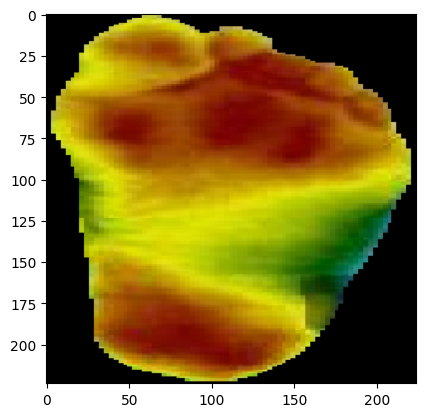

In [10]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))